In [2]:
from torch.utils.data import Dataset, DataLoader
from torch.nn import Embedding
from tqdm import tqdm
import torch
import torch.nn as nn
import json

In [3]:
relation_dict = {"Component-Whole(e2,e1)": 0, "Other": 1, "Instrument-Agency(e2,e1)": 2,
                 "Member-Collection(e1,e2)": 3, "Cause-Effect(e2,e1)": 4, "Entity-Destination(e1,e2)": 5,
                 "Content-Container(e1,e2)": 6, "Message-Topic(e1,e2)": 7, "Product-Producer(e2,e1)": 8,
                 "Member-Collection(e2,e1)": 9, "Entity-Origin(e1,e2)": 10, "Cause-Effect(e1,e2)": 11,
                 "Component-Whole(e1,e2)": 12, "Message-Topic(e2,e1)": 13, "Product-Producer(e1,e2)": 14,
                 "Entity-Origin(e2,e1)": 15, "Content-Container(e2,e1)": 16, "Instrument-Agency(e1,e2)": 17,
                 "Entity-Destination(e2,e1)": 18}

In [4]:
def data_processing(data_list: list):
    items = []
    for i in range(len(data_list)):
        items.append(json.loads(data_list[i]))
    return items

def data_load(items, words_dict):
    data = []
    for item in items:
        input = [words_dict[i] for i in item["token"]]
        label = [relation_dict[item["relation"]]]
        pad_num = 100 - len(input)
        for i in range(pad_num):
            input.append(words_dict["<PAD>"])
        data.append((torch.LongTensor(input), torch.LongTensor(label)))
    return data

In [5]:
json_list = []

with open("/kaggle/input/relation-extraction/semeval_train.txt", "r") as f:
    json_list = f.readlines()
    
with open("/kaggle/input/relation-extraction/semeval_val.txt", "r") as f:
    json_list += f.readlines()

with open("/kaggle/input/relation-extraction/semeval_test.txt", "r") as f:
    json_list += f.readlines()
    
items = data_processing(json_list)

In [6]:
test_json_list = []
with open("/kaggle/input/relation-extraction/semeval_test.txt", "r") as f:
    test_json_list = f.readlines()
    
test_items = data_processing(test_json_list)

In [7]:
words = set()
for item in items:
    for word in item["token"]:
        words.add(word)

words_test = set()
for item in test_items:
    for word in item["token"]:
        words_test.add(word)

#tokenize时的字典
words_dict = {}

for i, word in enumerate(words):
    words_dict[word] = i + 1
words_dict["<PAD>"] = 0

In [8]:
json_list = []

with open("/kaggle/input/relation-extraction/semeval_train.txt", "r") as f:
    json_list = f.readlines()
    
with open("/kaggle/input/relation-extraction/semeval_val.txt", "r") as f:
    json_list += f.readlines()

    
items = data_processing(json_list)

In [9]:
import random
random.shuffle(items)

In [10]:
data_list = data_load(items, words_dict)
test_data_list = data_load(test_items, words_dict)

In [11]:
len(data_list)

8000

In [12]:
def Pos_embedding(items):
    pos_embedding = []
    for item in items:
        pos_head = torch.zeros(100, dtype=torch.long)
        pos_tail = torch.zeros(100, dtype=torch.long)
        for j in range(100):
            if j < item["h"]["pos"][0]:
                pos_head[j] = j - item["h"]["pos"][0]+100
            if j > item["h"]["pos"][1]:
                pos_head[j] = j - item["h"]["pos"][1]+100
            if j < item["t"]["pos"][0]:
                pos_tail[j] = j - item["t"]["pos"][0]+100
            if j > item["t"]["pos"][1]:
                pos_tail[j] = j - item["t"]["pos"][1]+100
            pos_embedding.append((pos_head.view(-1, 1), pos_tail.view(-1, 1)))
    return pos_embedding

pos_embedding = Pos_embedding(items=items)
test_embedding = Pos_embedding(items=test_items)

In [13]:
class data_generator(Dataset):
    def __init__(self, data, pos_embedding) -> None:
        super().__init__()
        self.data = data
        self.pos_embedding = pos_embedding
    
    def __getitem__(self, index):
        return self.data[index][0], self.data[index][1], self.pos_embedding[index]
    
    def __len__(self):
        return len(self.data)

In [14]:
class CNNClassifier(nn.Module):
    def __init__(self, dict_size, embedding_size, pos_embedding_size, hidden_size, output_size) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.pos_embedding_size = pos_embedding_size
        self.embedding = Embedding(dict_size, embedding_size)
        
        self.pos_head_embedding = Embedding(200, pos_embedding_size)
        self.pos_tail_embedding = Embedding(200, pos_embedding_size)
        
        self.device = torch.device("cuda")
        
        self.features = nn.Sequential(
            nn.Conv1d(embedding_size + pos_embedding_size * 2, 768, kernel_size = 3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=1),
            nn.Conv1d(768, 1024, kernel_size = 5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=1),
            nn.Conv1d(1024, 512, kernel_size = 7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(5),
        )
        
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.4),
            nn.Linear(9216, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )
        
        self.pred = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, pos_vector, train: bool=True):
        if not train:
            self.layer[1] = nn.Dropout(p=0)
        
        batch_size = input.size()[0]
        input = self.embedding(input)
        pos_vector1 = self.pos_head_embedding(pos_vector[0].view(batch_size, -1).to(self.device))
        pos_vector2 = self.pos_tail_embedding(pos_vector[1].view(batch_size, -1).to(self.device))
        
        input = torch.cat((input, pos_vector1, pos_vector2), dim=-1)
        
        
        input = input.transpose(-2, -1).to(self.device)
        
        fx1 = self.features(input)
        return self.pred(self.layer(fx1))

In [15]:
class CNNClassifier2(nn.Module):
    def __init__(self, dict_size, embedding_size, pos_embedding_size, hidden_size, output_size) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.pos_embedding_size = pos_embedding_size
        self.embedding = Embedding(dict_size, embedding_size)
        
        self.pos_head_embedding = Embedding(200, pos_embedding_size)
        self.pos_tail_embedding = Embedding(200, pos_embedding_size)
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        
        self.features1 = nn.Sequential(
            nn.Conv1d(embedding_size + pos_embedding_size * 2, 300, kernel_size = 3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(3),
        )
        
        self.features2 = nn.Sequential(
            nn.Conv1d(embedding_size + pos_embedding_size * 2, 300, kernel_size = 9, padding=4),
            nn.ReLU(),
            nn.MaxPool1d(9),
        )
        
        self.features3 = nn.Sequential(
            nn.Conv1d(embedding_size + pos_embedding_size * 2, 300, kernel_size = 11, padding=5),
            nn.ReLU(),
            nn.MaxPool1d(11),
        )
        
        self.layer = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(15900, hidden_size),
            nn.ReLU(),
        )
        
        self.gate1 = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.gate2 = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.gate3 = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        
        self.gate1.data.fill_(0.33)
        self.gate2.data.fill_(0.33)
        self.gate3.data.fill_(0.33)
        
        self.pred = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, input, pos_vector, train: bool=True):
        if not train:
            self.layer[0] = nn.Dropout(p=0)
        
        batch_size = input.size()[0]
        input = self.embedding(input)
        pos_vector1 = self.pos_head_embedding(pos_vector[0].view(batch_size, -1).to(self.device))
        pos_vector2 = self.pos_tail_embedding(pos_vector[1].view(batch_size, -1).to(self.device))
        
        input = torch.cat((input, pos_vector1, pos_vector2), dim=-1)
        input = input.transpose(-2, -1).to(self.device)
        
        fx1 = self.features1(input) * self.gate1
        fx2 = self.features2(input) * self.gate2
        fx3 = self.features3(input) * self.gate3
        
        fx1 = torch.flatten(fx1, 1)
        fx2 = torch.flatten(fx2, 1)
        fx3 = torch.flatten(fx3, 1)
        
        fx = torch.cat((fx1, fx2, fx3), dim=-1)
        return self.pred(self.layer(fx))

In [16]:
class CNNClassifier3(nn.Module):
    def __init__(self, dict_size, embedding_size, pos_embedding_size, hidden_size, output_size) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.pos_embedding_size = pos_embedding_size
        self.embedding = Embedding(dict_size, embedding_size)
        
        self.pos_head_embedding = Embedding(200, pos_embedding_size)
        self.pos_tail_embedding = Embedding(200, pos_embedding_size)
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.features2 = nn.Sequential(
            nn.Conv1d(embedding_size + pos_embedding_size * 2, 100, kernel_size = 2),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=1),
        )
        
        self.features3 = nn.Sequential(
            nn.Conv1d(embedding_size + pos_embedding_size * 2, 100, kernel_size = 3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2),
        )
        
        self.features5 = nn.Sequential(
            nn.Conv1d(embedding_size + pos_embedding_size * 2, 100, kernel_size = 5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=3),
        )
        
        self.gate2 = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.gate3 = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.gate5 = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        
        
        self.gate2.data.fill_(0.33)
        self.gate3.data.fill_(0.33)
        self.gate5.data.fill_(0.33)
        
        
        self.layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(17900, hidden_size),
            nn.ReLU(),
        )
        
        self.pred = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, input, pos_vector, train: bool=True):
        if not train:
            self.layer[0] = nn.Dropout(p=0)
        
        batch_size = input.size()[0]
        input = self.embedding(input)
        pos_vector1 = self.pos_head_embedding(pos_vector[0].view(batch_size, -1).to(self.device))
        pos_vector2 = self.pos_tail_embedding(pos_vector[1].view(batch_size, -1).to(self.device))
        
        input = torch.cat((input, pos_vector1, pos_vector2), dim=-1)
        input = input.transpose(-2, -1).to(self.device)
        
        fx2 = self.features2(input) * torch.exp(self.gate2) / (torch.exp(self.gate2) + torch.exp(self.gate3) + torch.exp(self.gate5))
        fx3 = self.features3(input) * self.gate3 / (torch.exp(self.gate2) + torch.exp(self.gate3) + torch.exp(self.gate5))
        fx5 = self.features5(input) * self.gate5 / (torch.exp(self.gate2) + torch.exp(self.gate3) + torch.exp(self.gate5))
        
        fx2 = torch.flatten(fx2, 1)
        fx3 = torch.flatten(fx3, 1)
        fx5 = torch.flatten(fx5, 1)

        fx = torch.cat((fx2, fx3, fx5), dim=-1)
        return self.pred(self.layer(fx))

In [17]:
# cnn = CNNClassifier2(dict_size = len(words_dict)+1,
#                     embedding_size = 128,
#                     pos_embedding_size = 64,
#                     hidden_size = 256,
#                     output_size = 19
#                     )
# cnn = cnn.to(cnn.device)

In [18]:
cnn = CNNClassifier3(dict_size = len(words_dict)+1,
                    embedding_size = 128,
                    pos_embedding_size = 64,
                    hidden_size = 100,
                    output_size = 19
                    )
cnn = cnn.to(cnn.device)

In [19]:
print(cnn)

CNNClassifier3(
  (embedding): Embedding(23515, 128)
  (pos_head_embedding): Embedding(200, 64)
  (pos_tail_embedding): Embedding(200, 64)
  (features2): Sequential(
    (0): Conv1d(256, 100, kernel_size=(2,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (features3): Sequential(
    (0): Conv1d(256, 100, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (features5): Sequential(
    (0): Conv1d(256, 100, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=17900, out_features=100, bias=True)
    (2): ReLU()
  )
  (pred): Linear(in_features=100, out_features=19, bias=True)
)


In [20]:
dataset = data_generator(data=data_list[:-500], pos_embedding = pos_embedding[:-500])
dataloader = DataLoader(dataset=dataset,
                        batch_size=64,
                        shuffle=True)

dataset_val = data_generator(data=data_list[-500:], pos_embedding=pos_embedding[-500:])
dataloader_val = DataLoader(dataset=dataset_val,
                        batch_size=dataset_val.__len__(),
                        shuffle=True)

dataset2 = data_generator(data=test_data_list, pos_embedding = test_embedding)
dataloader2 = DataLoader(dataset=dataset2,
                        batch_size=dataset2.__len__())

In [21]:
loss_list = []
loss_list2 = []
accuracy_list = []

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=1e-3, weight_decay=0.001)
epochs = 200
for epoch in tqdm(range(epochs)):
    Loss = 0
    for data in dataloader:
        optimizer.zero_grad()
        input, output, pos_vector = data
        input, output = input.to(cnn.device), output.to(cnn.device)
        pred = cnn(input, pos_vector)
        loss = criterion(pred, output.view(-1))
        Loss += loss.item()
        loss.backward()
        # def closure():
        #     pred = cnn(input, pos_vector)
        #     loss = criterion(pred, output.view(-1))
        #     # print("batch loss: {:.9f}".format(loss.item()))
        #     loss.backward()
        #     return loss
        optimizer.step()
    loss_list.append(Loss)
    Loss2 = 0
    for data in dataloader_val:
        input, output, pos_vector = data
        input, output = input.to(cnn.device), output.to(cnn.device)
        pred = cnn(input, pos_vector, train=False)
        loss = criterion(pred, output.view(-1))
        Loss2 += loss.item()
    loss_list2.append(Loss2)
    if (epoch + 1) % 5 == 0 or epoch == 0:
        correct = 0
        print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.4f}'.format(Loss))
        print('Epoch:', '%04d' % (epoch + 1), 'val loss =', '{:.4f}'.format(Loss2))
        for data in dataloader2:
            input, output, pos_vector = data
            input, output = input.to(cnn.device), output.to(cnn.device)
            pred = cnn(input, pos_vector, train=False)
            pred = pred.argmax(dim=1)
            correct += torch.sum(pred == output.view(-1)).item()
        print("accuracy:", correct/len(test_data_list))
        accuracy_list.append(correct/len(test_data_list))
    if (epoch + 1) % 100 == 0 or Loss < 5:
        optimizer = torch.optim.Adam(params=cnn.parameters(), lr=1e-5,  weight_decay=0.001)

  0%|          | 1/200 [00:07<25:34,  7.71s/it]

Epoch: 0001 loss = 303.9651
Epoch: 0001 val loss = 2.4728
accuracy: 0.2326094957673905


  2%|▎         | 5/200 [00:12<05:57,  1.83s/it]

Epoch: 0005 loss = 183.7849
Epoch: 0005 val loss = 2.0940
accuracy: 0.3868237026131763


  5%|▌         | 10/200 [00:19<04:18,  1.36s/it]

Epoch: 0010 loss = 72.8009
Epoch: 0010 val loss = 2.4329
accuracy: 0.3665807876334192


  8%|▊         | 15/200 [00:25<03:56,  1.28s/it]

Epoch: 0015 loss = 23.5619
Epoch: 0015 val loss = 2.8983
accuracy: 0.368052999631947


 10%|█         | 20/200 [00:31<03:43,  1.24s/it]

Epoch: 0020 loss = 14.6351
Epoch: 0020 val loss = 2.8388
accuracy: 0.40264998159735


 12%|█▎        | 25/200 [00:37<03:37,  1.24s/it]

Epoch: 0025 loss = 13.4167
Epoch: 0025 val loss = 2.6952
accuracy: 0.3986013986013986


 15%|█▌        | 30/200 [00:43<03:29,  1.24s/it]

Epoch: 0030 loss = 10.4560
Epoch: 0030 val loss = 2.5678
accuracy: 0.4177401545822598


 18%|█▊        | 35/200 [00:50<03:34,  1.30s/it]

Epoch: 0035 loss = 10.3197
Epoch: 0035 val loss = 2.3828
accuracy: 0.4626426205373574


 20%|██        | 40/200 [00:56<03:23,  1.27s/it]

Epoch: 0040 loss = 7.6978
Epoch: 0040 val loss = 2.3322
accuracy: 0.47810084652189916


 22%|██▎       | 45/200 [01:02<03:11,  1.24s/it]

Epoch: 0045 loss = 8.3661
Epoch: 0045 val loss = 2.4436
accuracy: 0.4950312845049687


 25%|██▌       | 50/200 [01:09<03:08,  1.26s/it]

Epoch: 0050 loss = 10.1677
Epoch: 0050 val loss = 2.3779
accuracy: 0.48509385351490614


 28%|██▊       | 55/200 [01:15<02:59,  1.24s/it]

Epoch: 0055 loss = 5.8311
Epoch: 0055 val loss = 2.2863
accuracy: 0.5215311004784688


 30%|███       | 60/200 [01:21<02:57,  1.26s/it]

Epoch: 0060 loss = 6.9447
Epoch: 0060 val loss = 2.3690
accuracy: 0.5012881854987118


 32%|███▎      | 65/200 [01:27<02:47,  1.24s/it]

Epoch: 0065 loss = 5.0845
Epoch: 0065 val loss = 2.4200
accuracy: 0.5266838424733161


 35%|███▌      | 70/200 [01:33<02:41,  1.25s/it]

Epoch: 0070 loss = 3.0826
Epoch: 0070 val loss = 2.2192
accuracy: 0.528156054471844


 38%|███▊      | 75/200 [01:40<02:38,  1.27s/it]

Epoch: 0075 loss = 4.1207
Epoch: 0075 val loss = 2.1924
accuracy: 0.5252116304747884


 40%|████      | 80/200 [01:46<02:28,  1.23s/it]

Epoch: 0080 loss = 5.2091
Epoch: 0080 val loss = 2.1773
accuracy: 0.5244755244755245


 42%|████▎     | 85/200 [01:52<02:26,  1.28s/it]

Epoch: 0085 loss = 4.9299
Epoch: 0085 val loss = 2.1731
accuracy: 0.5252116304747884


 45%|████▌     | 90/200 [01:58<02:16,  1.24s/it]

Epoch: 0090 loss = 5.1559
Epoch: 0090 val loss = 2.1686
accuracy: 0.5255796834744203


 48%|████▊     | 95/200 [02:04<02:10,  1.24s/it]

Epoch: 0095 loss = 5.0086
Epoch: 0095 val loss = 2.1671
accuracy: 0.5222672064777328


 50%|█████     | 100/200 [02:11<02:03,  1.23s/it]

Epoch: 0100 loss = 5.3321
Epoch: 0100 val loss = 2.1654
accuracy: 0.5226352594773648


 52%|█████▎    | 105/200 [02:17<01:58,  1.24s/it]

Epoch: 0105 loss = 5.0549
Epoch: 0105 val loss = 2.1672
accuracy: 0.5237394184762606


 55%|█████▌    | 110/200 [02:23<01:56,  1.29s/it]

Epoch: 0110 loss = 4.9757
Epoch: 0110 val loss = 2.1638
accuracy: 0.5226352594773648


 57%|█████▊    | 115/200 [02:29<01:45,  1.24s/it]

Epoch: 0115 loss = 5.3619
Epoch: 0115 val loss = 2.1663
accuracy: 0.5233713654766287


 60%|██████    | 120/200 [02:35<01:40,  1.26s/it]

Epoch: 0120 loss = 5.2880
Epoch: 0120 val loss = 2.1671
accuracy: 0.5222672064777328


 62%|██████▎   | 125/200 [02:42<01:33,  1.24s/it]

Epoch: 0125 loss = 5.1963
Epoch: 0125 val loss = 2.1698
accuracy: 0.5222672064777328


 65%|██████▌   | 130/200 [02:48<01:27,  1.25s/it]

Epoch: 0130 loss = 5.0865
Epoch: 0130 val loss = 2.1713
accuracy: 0.5241074714758925


 68%|██████▊   | 135/200 [02:54<01:22,  1.27s/it]

Epoch: 0135 loss = 5.0202
Epoch: 0135 val loss = 2.1713
accuracy: 0.5244755244755245


 70%|███████   | 140/200 [03:00<01:14,  1.25s/it]

Epoch: 0140 loss = 4.9595
Epoch: 0140 val loss = 2.1721
accuracy: 0.5244755244755245


 72%|███████▎  | 145/200 [03:06<01:08,  1.24s/it]

Epoch: 0145 loss = 5.3827
Epoch: 0145 val loss = 2.1805
accuracy: 0.5222672064777328


 75%|███████▌  | 150/200 [03:13<01:02,  1.24s/it]

Epoch: 0150 loss = 5.3062
Epoch: 0150 val loss = 2.1806
accuracy: 0.5233713654766287


 78%|███████▊  | 155/200 [03:19<00:57,  1.27s/it]

Epoch: 0155 loss = 5.2248
Epoch: 0155 val loss = 2.1817
accuracy: 0.5222672064777328


 80%|████████  | 160/200 [03:25<00:50,  1.27s/it]

Epoch: 0160 loss = 5.1281
Epoch: 0160 val loss = 2.1818
accuracy: 0.5237394184762606


 82%|████████▎ | 165/200 [03:31<00:43,  1.25s/it]

Epoch: 0165 loss = 5.0795
Epoch: 0165 val loss = 2.1861
accuracy: 0.5237394184762606


 85%|████████▌ | 170/200 [03:38<00:37,  1.23s/it]

Epoch: 0170 loss = 4.9890
Epoch: 0170 val loss = 2.1897
accuracy: 0.5244755244755245


 88%|████████▊ | 175/200 [03:44<00:31,  1.24s/it]

Epoch: 0175 loss = 4.9153
Epoch: 0175 val loss = 2.1915
accuracy: 0.5241074714758925


 90%|█████████ | 180/200 [03:50<00:24,  1.24s/it]

Epoch: 0180 loss = 5.3520
Epoch: 0180 val loss = 2.1954
accuracy: 0.5226352594773648


 92%|█████████▎| 185/200 [03:56<00:19,  1.28s/it]

Epoch: 0185 loss = 5.2851
Epoch: 0185 val loss = 2.1963
accuracy: 0.5222672064777328


 95%|█████████▌| 190/200 [04:03<00:12,  1.28s/it]

Epoch: 0190 loss = 5.1994
Epoch: 0190 val loss = 2.1961
accuracy: 0.5237394184762606


 98%|█████████▊| 195/200 [04:09<00:06,  1.24s/it]

Epoch: 0195 loss = 5.1055
Epoch: 0195 val loss = 2.1981
accuracy: 0.5237394184762606


100%|██████████| 200/200 [04:15<00:00,  1.28s/it]

Epoch: 0200 loss = 4.9942
Epoch: 0200 val loss = 2.2001
accuracy: 0.5244755244755245


In [1]:
cnn.gate2, cnn.gate3, cnn.gate5

NameError: name 'cnn' is not defined

In [24]:
import numpy as np
ep = np.linspace(0, 200, 41)
ep

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
       165., 170., 175., 180., 185., 190., 195., 200.])

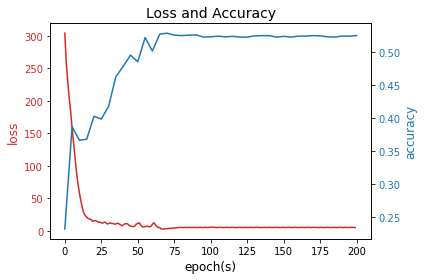

In [25]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('epoch(s)', fontsize = 12)
ax1.set_ylabel('loss', color=color, fontsize = 12)
ax1.plot(loss_list, color=color, label="loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title("Loss and Accuracy", fontsize = 14)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color, fontsize = 12)  # we already handled the x-label with ax1
ax2.plot(ep, accuracy_list, color=color, label="accuracy")
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("re1.pdf")

In [26]:
correct = 0
for data in dataloader_val:
    input, output, pos_vector = data
    input, output = input.to(cnn.device), output.to(cnn.device)
    pred = cnn(input, pos_vector, train=False)
    pred = pred.argmax(dim=1)
    correct += torch.sum(pred == output.view(-1)).item()
print("accuracy:", correct/dataset_val.__len__())

accuracy: 0.456


In [27]:
dataset2 = data_generator(data=test_data_list, pos_embedding = test_embedding)
dataloader2 = DataLoader(dataset=dataset2,
                        batch_size=dataset2.__len__())

correct = 0
for data in dataloader2:
    input, output, pos_vector = data
    input, output = input.to(cnn.device), output.to(cnn.device)
    pred = cnn(input, pos_vector, train=False)
    pred = pred.argmax(dim=1)
    correct += torch.sum(pred == output.view(-1)).item()

# len(test_data_list)
print("accuracy:", correct/len(test_data_list))

accuracy: 0.5244755244755245


In [28]:
from torchmetrics import F1Score
test_f1score = F1Score(num_classes=19, threshold = 1. / 5, average="macro").to(cnn.device)

In [29]:
for data in dataloader2:
    input, output, pos_vector = data
    input, output = input.to(cnn.device), output.to(cnn.device)
    pred = cnn(input, pos_vector, train=False)
    pred = pred.argmax(dim=1)
    print("recall:", test_f1score(pred, output.view(-1)))

recall: tensor(0.4660, device='cuda:0')
